# Analyse des comportements de joueurs menant à la victoire

Le but de ce projet est d'effectuer une analyse stochastique des comportements de joueur sur le jeu League of Legends.

## Contexte

League of Legends est un jeu multijoueur en ligne faisant s'affronter deux équipes de 5 joueurs.
De nombreuses données peuvent être extraites de chaque partie, ces données sont soit liées à la partie en sa globalité, soit à chaque joueur en particulier.

Dans ce projet, nous avons décidé de nous concentrer sur les données d'un joueur de manière individuelle. Cela va nous permettre d'analyser ses changements de comportements et de les comparer avec ses résultats au cours des parties (si un comportement x augmente le taux de victoire ou le fait baisser).

## Traitement des données

Afin d'obtenir des résultats plus justes et cohérents, nous avons choisi de trier les parties en fonction du rôle ainsi que du champion du joueur dans chaque partie. En effet, les différents rôles et champions impliquent déjà des comportements différents, simplement par les règles de jeu. Cela fausserait donc nos résultats.
Finalement, nous nous intéressons seulement aux parties avec classement, car elles sont plus sérieuses étant donné qu'elles ont un enjeu de 'elo', tout comme aux échecs.

Pour résumer nous fixons donc trois variables :
- Le joueur
- Un rôle
- Un champion

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Pseudo du joueur
summoner_name = "Phoque+éberlué"
# ID du joueur
summoner_id = 'WQF87iAxVYxyVgB6W1hY4TLuNBGZoNnpKynKHaKI19-S592f'

In [3]:
# Chargement du fichier de résumé des parties
with open(f'../out/{summoner_name}_summuary.json') as file:
    summary = json.load(file)

In [4]:
# Historique des parties du joueur, avec le résultat de la partie et le champion joué
summary

{'EUW1_6136998966': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136940073': {'win': True, 'champion': 'Rammus'},
 'EUW1_6136905434': {'win': True, 'champion': 'Rammus'},
 'EUW1_6136879159': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136851586': {'win': False, 'champion': 'Akshan'},
 'EUW1_6136817008': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136214910': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136106763': {'win': False, 'champion': 'Rammus'},
 'EUW1_6136051197': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135708038': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135635897': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135581703': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135534759': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135497604': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135468291': {'win': False, 'champion': 'Rammus'},
 'EUW1_6135430029': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135407108': {'win': True, 'champion': 'Rammus'},
 'EUW1_6135385443': {

## Les paramètres retenus

Les données offertes par l'API du jeu sont nombreuses (~150 variables par joueurs), il serait donc très long et complexe avec nos connaissances actuelles d'effectuer une analyse efficace et pertinente sur autant de paramètres. Nous nous concentrerons ainsi sur quelque uns de ces paramètres et effectuerons une analyse monovariée.

Nous avons retenu ces différents paramètres :
- Le nombre de fois que le joueur est mort lors de la partie
- Son nombre d'ennemis tués
- Son nombre d'assistances portées à son équipe
- Le nombre total de 'pings' utilisé (système permettant de communiquer rapidement avec son équipe)
- Le nombre d'argent que le joueur a dépensé lors de la partie
- Si la partie a été remportée

In [5]:
# Instanciation des différents tableaux de données
deaths = np.full(len(summary), np.nan)
kills = np.full(len(summary), np.nan)
assists = np.full(len(summary), np.nan)
total_pings = np.full(len(summary), np.nan)
goldSpent = np.full(len(summary), np.nan)
wins = np.full(len(summary), np.nan)

In [6]:
i = 0

# Parcours des parties du joueur
for game_id, dic in summary.items():
    # Si le champion n'est pas 'Rammus' on ignore la partie
    if dic['champion'] != 'Rammus':
        continue

    # Ouverture du fichier de la partie
    with open(f'../out/{summoner_name}_{game_id}.json') as file:
        game_data = json.load(file)

    participants_data = game_data['info']['participants']

    # Parcours des données de tous les joueurs de la partie
    for participant_data in participants_data:
        # On récupère seulement les données de notre joueur
        if participant_data['summonerId'] == summoner_id:

            # Ignore les parties annulées à cause d'un absent
            if participant_data['gameEndedInEarlySurrender']:
                break

            deaths[i] = participant_data['deaths']
            kills[i] = participant_data['kills']
            assists[i] = participant_data['assists']
            goldSpent[i] = participant_data['goldSpent']
            wins[i] = participant_data['win']

            # Récupération du nombre total de 'ping' (moyens de communication avec son équipe)
            if 'allInPings' in participant_data:
                total_pings[i] = participant_data['allInPings'] + \
                                 participant_data['assistMePings'] + \
                                 participant_data['baitPings'] + \
                                 participant_data['basicPings'] + \
                                 participant_data['dangerPings'] + \
                                 participant_data['commandPings'] + \
                                 participant_data['dangerPings'] + \
                                 participant_data['enemyMissingPings'] + \
                                 participant_data['enemyVisionPings'] + \
                                 participant_data['getBackPings'] + \
                                 participant_data['holdPings'] + \
                                 participant_data['needVisionPings'] + \
                                 participant_data['onMyWayPings'] + \
                                 participant_data['pushPings'] + \
                                 participant_data['visionClearedPings']
            elif 'basicPings' in participant_data:
                total_pings[i] = participant_data['basicPings']
            else:
                total_pings[i] = np.nan

    i+=1

In [7]:
# Suppression des NaN, et renversement des tableaux pour mettre les parties dans l'ordre chronologique
deaths = np.flip(deaths[~np.isnan(deaths)])
kills = np.flip(kills[~np.isnan(kills)])
assists = np.flip(assists[~np.isnan(assists)])
total_pings = np.flip(total_pings[~np.isnan(total_pings)])
goldSpent = np.flip(goldSpent[~np.isnan(goldSpent)])
wins = np.flip(wins[~np.isnan(wins)])

In [8]:
# Nombre de parties gardées au final
len(deaths)

618

# Calcul de vraissemblance sur les paramètres

Nous allons maintenant effectuer la vraissemblance sur nos différents paramètres. Cela nous permettra d'identifier des changements de comportements sur nos différents paramètres au fil du temps. À noter que les parties ont été triés de la plus veille à la plus récente. Dans cet exemple, elles ont été jouées au cours de l'année 2022 de janvier à octobre.

In [9]:
# Moyenne de morts du joueur par partie
np.mean(deaths)

5.679611650485437

In [10]:
np.cov(deaths)

array(9.44985917)

In [11]:
# Vraissemblance monovarie
def vraissemblanceMonovarie(m, n, variance):
    return - (n - m + 1)/2 * (1 + np.log(2 * np.pi * (variance ** 2)))

In [12]:
# Calcul de la vraissemblance globale
def vraissemblanceGlobale(data, step = 1, window_len = 30):
    nb_valeurs = int((len(data) - window_len) / step)
    vraiss_avant = np.zeros(nb_valeurs)
    vraiss_apres = np.zeros(nb_valeurs)
    t = len(data)

    i = 0
    for m in range(window_len, len(data), step):
        vraiss_avant[i] = vraissemblanceMonovarie(1, m, np.cov(data[0:m]))
        vraiss_apres[i] = vraissemblanceMonovarie(m + 1, t, np.cov(data[m+1:t-1]))
        i += 1

    vraiss_totale = vraiss_avant + vraiss_apres

    return vraiss_totale

In [ ]:
# Calcul des vraissemblance de nos différents paramètres
deaths_vraiss_totale = vraissemblanceGlobale(deaths)
kills_vraiss_totale = vraissemblanceGlobale(kills)
assists_vraiss_totale = vraissemblanceGlobale(assists)
total_pings_vraiss_totale = vraissemblanceGlobale(total_pings)
goldSpent_vraiss_totale = vraissemblanceGlobale(goldSpent)

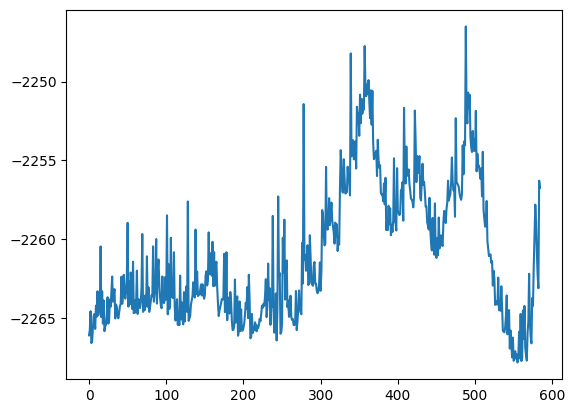

In [14]:
plt.plot(deaths_vraiss_totale)

Concernant la vraissemblance du nombre de morts par parties du joueur, on constate un grand changement de comportement vers la 300ᵉ partie.

La moyenne de morts est légérement plus basse sur la deuxième moitié de l'année.

In [15]:
print(f'Moyenne de mort avant 300: {np.mean(deaths[0:300])}')
print(f'Moyenne de mort après 300: {np.mean(deaths[300:550])}')

print(f'Cov de mort avant 300: {np.cov(deaths[0:300])}')
print(f'Cov de mort après 300: {np.cov(deaths[300:550])}')


Moyenne de mort avant 300: 5.85
Moyenne de mort après 300: 5.684
Cov de mort avant 300: 9.552675585284284
Cov de mort après 300: 9.622634538152612


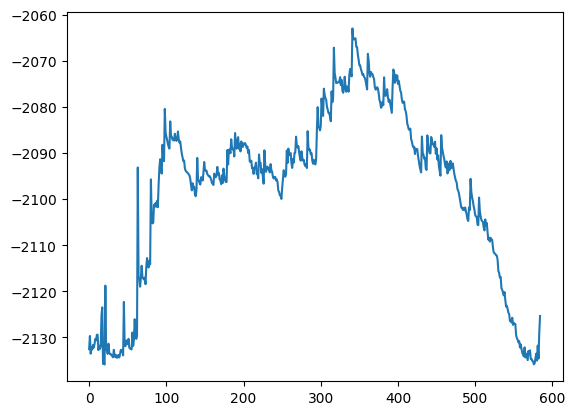

In [16]:
plt.plot(kills_vraiss_totale)

Pour la vraissemblance du nombre d'ennemis tués, on constate une séparation similaire à celle précedente.

Cependant, le nombre de kills sur la deuxième moitié de l'année est largement plus bas, de même pour la covariance.

In [17]:
print(f'Moyenne de kills avant 300: {np.mean(kills[0:300])}')
print(f'Moyenne de kills après 300: {np.mean(kills[300:550])}')

print(f'Cov de kills avant 300: {np.cov(kills[0:300])}')
print(f'Cov de kills après 300: {np.cov(kills[300:550])}')


Moyenne de kills avant 300: 4.24
Moyenne de kills après 300: 3.312
Cov de kills avant 300: 9.346889632107025
Cov de kills après 300: 5.749654618473897


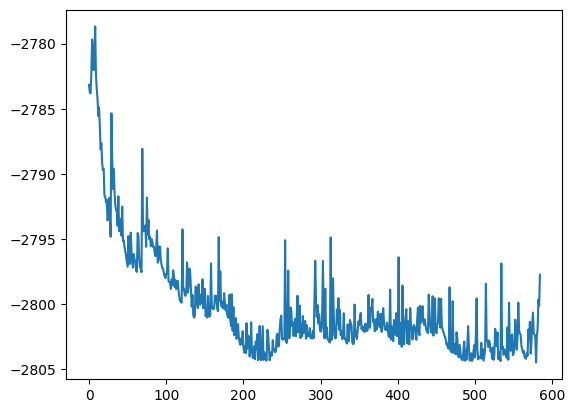

In [18]:
plt.plot(assists_vraiss_totale)

La moyenne du nombre d'assistances quant à elle monte et la covariance baisse légèrement.

On remarque toujours deux phases distinctes sur la vraissemblance.

In [19]:
print(f'Moyenne d\'assists  avant 300: {np.mean(assists[0:300])}')
print(f'Moyenne d\'assists après 300: {np.mean(assists[300:550])}')

print(f'Cov d\'assists 300: {np.cov(assists[0:300])}')
print(f'Cov d\'assists 300: {np.cov(assists[300:550])}')


Moyenne d'assists  avant 300: 7.41
Moyenne d'assists après 300: 7.996
Cov d'assists 300: 23.03869565217391
Cov d'assists 300: 22.172674698795184


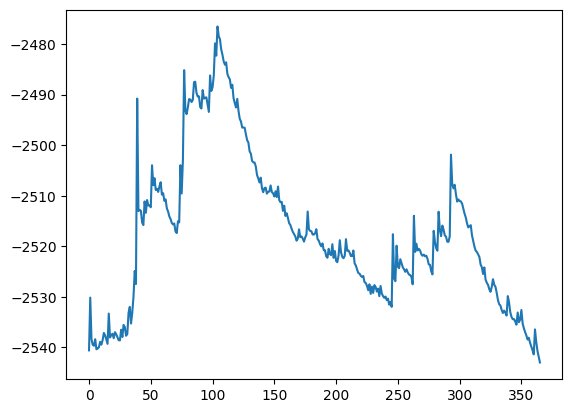

In [20]:
plt.plot(total_pings_vraiss_totale)

Ici le graph n'a pas la même taille en X, car ces données étaient manquantes dans la moitié des parties.

L'analyse de ce paramètre nous semble donc moins pertinente, car les données ne respecte pas la chronologie que nous nous sommes fixée.

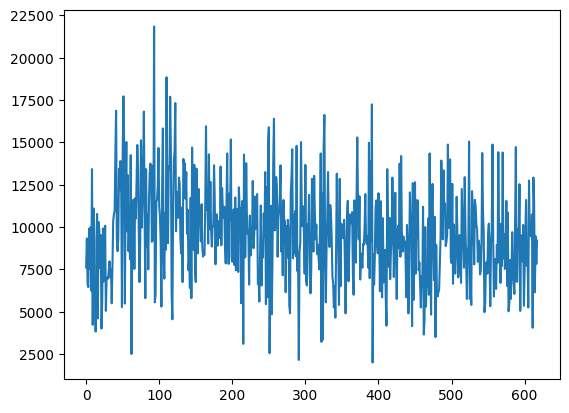

In [21]:
plt.plot(goldSpent)

Finalement la vraissemblance de l'argent dépensé ne nous semble pas exploitable, nous la laisserons donc de côté car les autres paramètres ont l'air beaucoup plus intéressants.

# Affichage de la progression du joueur (Victoire/Défaite)

Nous allons maintenant effectuer un affichage de l'évolution du joueur dans le classement en faisant une courbe d'évolution de ses victoires et défaites.
Cela va nous permettre de mettre en relation les changements de comportements des différents paramètres avec l'évolution du joueur dans le classement. Ainsi nous pourront évaluer les paramètres influant le plus sur l'issue des parties.

In [22]:
print(wins)

[1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0.

In [23]:
win_evolution = np.zeros(len(wins))
win_count = 0
i = 0

# Pour chaque partie
for w in wins:
    if w:
       win_count += 1
    else:
        win_count -= 1
    win_evolution[i] = win_count
    i+=1

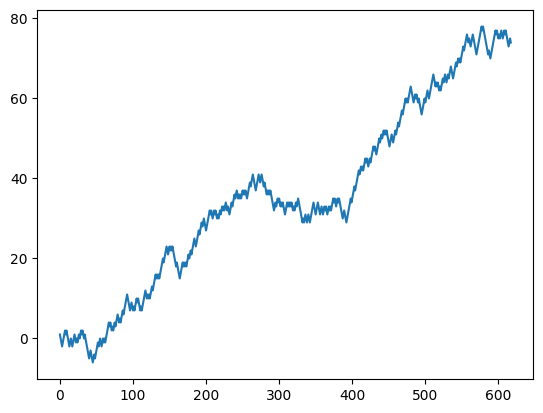

In [24]:
plt.plot(win_evolution)

## Analyse des résultats

Sur le graph de l'évolution du joueur, on remarque trois périodes de tendances :
- Au début de l'année le joueur a eu une progression rapide et plutôt constante.
- Au bout de la 220ᵉ partie et jusqu'à la 350ᵉ il n'y a eu aucune progression et le joueur a stagné.
- Sur la dernière moitié de l'année le joueur a eu une nouvelle progression, bien plus grande que la première, avant de se stabiliser à la fin de l'année (fin de saison 2022 des matchs classés).

Ces trois périodes vont donc nous permettre de comparer les analyse de vraissemblance entre elles afin de voir pourquoi est-ce que le joueur s'est soudainement mit à stagner, et pourquoi s'est t'il mit à progresser de nouveau.

### Nombre de morts

Commençons par mettre en relation le nombre de morts du joueur en fonction de ses victoires.

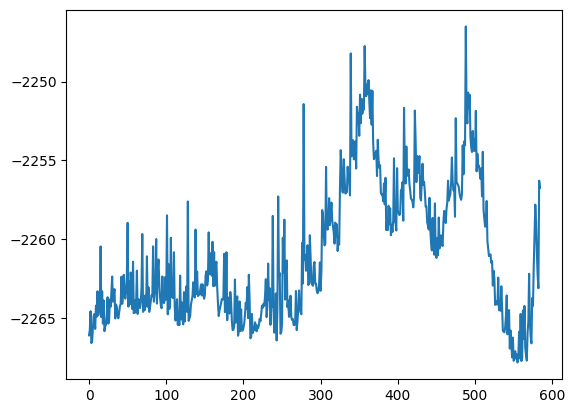

In [25]:
plt.plot(deaths_vraiss_totale)

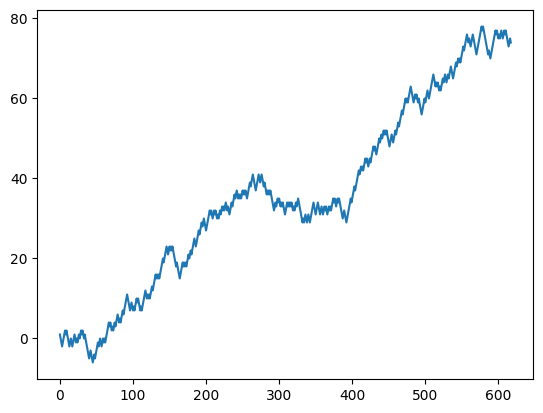

In [26]:
plt.plot(win_evolution)

On constate que les deux phases que nous avions identifiées lors de la partie vraissemblance, enveloppent la phase de stagnation du joueur.

Un changement de comportement a lieu à la 300ᵉ partie, cependant le changement ne va pas affecter tout de suite la progression du joueur, il faudra attendre 100 autres parties avant que le joueur ne se remette à progresser.

In [43]:
print(f"Mean number of deaths in first phase: {np.mean(deaths[0:250])}")
print(f"Mean number of deaths in stagnation phase: {np.mean(deaths[250:400])}")
print(f"Mean number of deaths in last phase: {np.mean(deaths[400:len(deaths)])}")

Mean number of deaths in first phase: 5.716
Mean number of deaths in stagnation phase: 6.373333333333333
Mean number of deaths in last phase: 5.160550458715596


En comparant les moyennes de morts du joueur sur ces trois phases, on se rend que compte que ce nombre est bien plus élevé lors de la période de stagnation, alors qu'il chute considérablement lors de la dernière phase de progression.

On peut donc en déduire que ce paramètre est très important concernant l'issue de la victoire.

### Nombre de kills

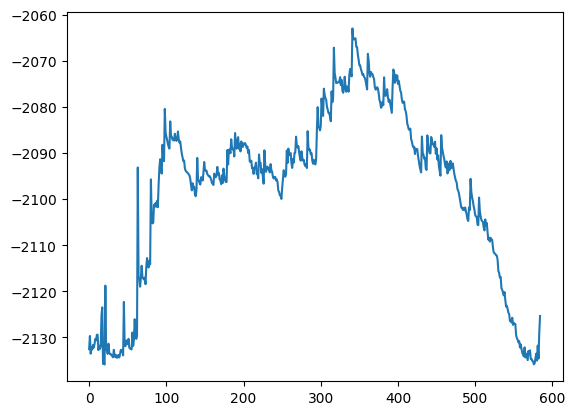

In [29]:
plt.plot(kills_vraiss_totale)

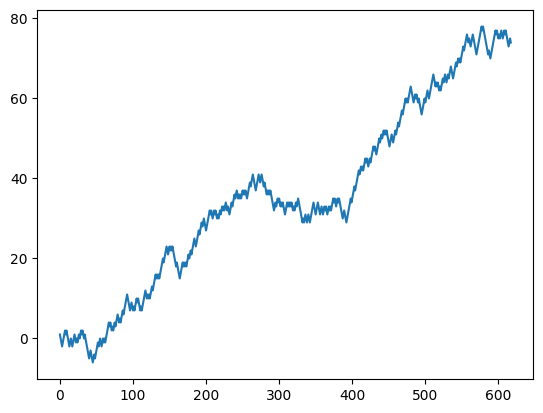

In [31]:
plt.plot(win_evolution)

In [44]:
print(f"Mean number of kills in first phase: {np.mean(kills[0:250])}")
print(f"Mean number of kills in stagnation phase: {np.mean(kills[250:400])}")
print(f"Mean number of kills in last phase: {np.mean(kills[400:len(kills)])}")

Mean number of kills in first phase: 4.312
Mean number of kills in stagnation phase: 3.78
Mean number of kills in last phase: 2.876146788990826


Ici, contrairement aux paramètres de morts, on remarque clairement une rupture au moment exact ou le joueur cesse de stagner (partie 400).

On constate à ce moment que le nombre de kills en moyenne du joueur baisse radicalement, quasiment divisé par deux comparé au début de l'année. Cependant, cela paraît contre intuitif, on aurait pu penser que si le joueur effectuait plus de kills il gagnerait plus de parties.

Il faut donc recontextualiser ces données. On a vu précédemment que le joueur à commencer à mourir de moins en moins vers la fin de l'année. Cela peut être traduit par des phases de jeu beaucoup plus prudentes et avec moins de prises de risques.
On pourrait ainsi expliquer le nombre de kills qui baisse par un changement de comportement quant à l'agressivité dans la façon de jouer du joueur.

In [45]:
print(f"Variance of kills in first phase: {np.cov(kills[0:250])}")
print(f"Variance of kills in stagnation phase: {np.cov(kills[250:400])}")
print(f"Variance of kills in last phase: {np.cov(kills[400:len(kills)])}")

Variance of kills in first phase: 9.524755020080322
Variance of kills in stagnation phase: 7.608993288590602
Variance of kills in last phase: 4.431594300934343


Par ailleurs nous avions vu que la variance était quasiment divisée par deux sur la fin de l'année lors de l'analyse de vraissemblance.

En décomposant la variance sur les trois phases, on remarque bien qu'elle chute au cours des différentes phases.

Cela vient encore plus appuyer notre point, et nous indique que le joueur a été beaucoup plus constant et a pris moins de risques lors de la fin de l'année.

Pour conclure avec ce paramètre, il est en fait plutôt correct que le nombre de kills descende malgré une progression dans le classement, car les ennemis devenant plus expérimentés, auront moins tendance à mourir lors des parties. Pour appuyer cet argument, le nombre moyen de morts qui est beaucoup plus bas dans les parties à plus haut niveau. Il est donc plutôt normal que cette moyenne baisse lors d'une progression.

### Nombre d'assistances

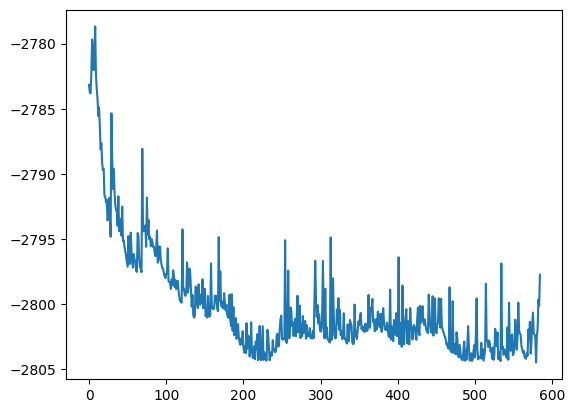

In [34]:
plt.plot(assists_vraiss_totale)

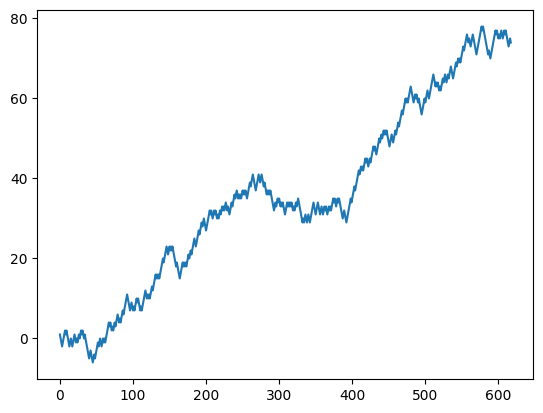

In [35]:
plt.plot(win_evolution)

In [40]:
print(f"Mean number of assists in first phase: {np.mean(assists[0:250])}")
print(f"Mean number of assists in stagnation phase: {np.mean(assists[200:400])}")
print(f"Mean number of assists in last phase: {np.mean(assists[400:len(assists)])}")

Mean number of assists in first phase: 7.708
Mean number of assists in stagnation phase: 6.815
Mean number of assists in last phase: 8.0


Pour le dernier paramètre, on constate des caractèristiques très similaires à celles des morts, mais dans le sens inverse.
Ici il faut plutôt maximiser son nombre d'assistances afin de voir un impact positif sur sa progression.

On constate que la phase de stagnation est marquée par une baisse du nombre d'assistances portées à l'équipe.

C'est ici une analyse plutôt triviale étant donné qu'il s'agit d'un jeu de stratégie en équipe portant sur la collaboration entre les différents joueurs pour gagner une partie.

# Conclusion

Pour conclure, nous avons analysé 3 paramètres nous semblants essentiels et reflétant le style de jeu du joueur.
De ces paramètres, nous avons trouvé que :

Un nombre de morts trop grand freine la progression d'un joueur, mais que le réduire ne suffit pas à lui seul pour progresser.

Il ne faut pas forcément chercher à maximiser son nombre de kills, mais plutôt à acquérir de la constance en adoptant un style de jeu plus sûr et précis.

Il est important d'augmenter son nombre d'assistances, car il est très lié à la progression.

# Pour aller plus loin...

Cette analyse fut très intéressante, mais nous pensons que nous aurions pu aller beaucoup plus loins avec des outils plus avancés, notamment avec des outils multivariés.

Il sera donc très intéressant d'utiliser à nouveau ces données pour le prochain projet. Nous pourrons ainsi analyser beaucoup plus de paramètres et évaluer de manière plus précise les corrélations entre ces derniers.

### Note du joueur dont les données ont été analysées

"Je trouve l'analyse très pertinente concernant la façon dont j'ai vécu cette saison de parties classées. J'ai beaucoup gagné sur le début de la saison car le elo des joueurs est remi à zéro, les adversaires que j'affrontais étaient moins forts. Vers le milieu de la saison j'ai commencé à stagner car je jouais contre des gens de mon niveau. J'ai donc essayé de m'améliorer en essayant de jouer de manière plus aggressive et cela se voit sur mon nombre moyen de morts. Cela ne fonctionnait pas du tout donc j'ai totalement changé ma façon de jouer pour être plus réfléchi et en prenant moins de risques. J'ai également réduit le nombre de parties que j'effectuais par jours, me permettant d'être plus concentré dans chaques parties. L'espacement de temps entre les parties est donc une dimension qui aurait pu être analysée."

Phoque éberlué - top 0.003% des meilleurs joueurs du jeu.